# deliriumviz.py


In [ ]:
def corrections_loader(fecha_inicio, fecha_fin):
    """
    Función que procesa reportes de correcciones en formato HTML dentro de un rango de fechas
    y genera un archivo Excel consolidado con los resultados.

    Parámetros
    ----------
    fecha_inicio : "%Y-%m-%d"
        Fecha inicial del rango a procesar (formato datetime).
    fecha_fin : "%Y-%m-%d"
        Fecha final del rango a procesar (formato datetime).

    Retorna
    -------
    df_final : pandas.DataFrame
        DataFrame consolidado con las correcciones extraídas de los archivos HTML.
        Si ocurre un error o no se encuentran archivos, retorna un DataFrame vacío.
    """

    # Librerías
    import pandas as pd
    import os
    from datetime import timedelta
    from zoneinfo import ZoneInfo
    from bs4 import BeautifulSoup
    import re
    from openpyxl import load_workbook

    zona_local = "America/Santiago"
    ruta_base = "$repository/data/"
    nombre_base = "corrections_report"
    formato_fecha = "%Y-%m-%d"

    resultados = []

    # Validar tipos de fecha
    if not hasattr(fecha_inicio, "strftime") or not hasattr(fecha_fin, "strftime"):
        raise ValueError("fecha_inicio y fecha_fin deben ser objetos datetime")

    # Convertir fechas a UTC (con protecciones de error)
    try:
        dt_inicio_utc = fecha_inicio.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
        dt_fin_utc = fecha_fin.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
    except Exception as e:
        print(f"Error convirtiendo fechas a UTC: {e}")
        return pd.DataFrame()

    fecha_actual = fecha_inicio
    while fecha_actual <= fecha_fin:
        fecha_str = fecha_actual.strftime(formato_fecha)
        anio = fecha_actual.strftime("%Y")
        mes = fecha_actual.strftime("%m")
        path = os.path.join(ruta_base, anio, mes, f"{nombre_base}_{fecha_str}.html")
        nombre_archivo = f"{nombre_base}_{fecha_str}.html"

        if os.path.exists(path):
            try:
                with open(path, "r", encoding="utf-8") as f:
                    html = f.read()
                soup = BeautifulSoup(html, "lxml")

                # Intentar leer tablas
                try:
                    tablas = pd.read_html(path, index_col=0)
                except Exception as e:
                    print(f"Error leyendo tablas en {nombre_archivo}: {e}")
                    tablas = []

                for i in range(0, len(tablas) - 1, 2):
                    try:
                        n_repeat = tablas[i + 1].shape[0]
                        tabla_transpuesta = tablas[i].T

                        if all(col in tabla_transpuesta.columns for col in ["Timestamp", "Delay line number"]):
                            test_pd = tabla_transpuesta[["Timestamp", "Delay line number"]].copy()

                            # Convertir Timestamp
                            try:
                                test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"], errors="coerce")
                            except Exception as e:
                                print(f"Error convirtiendo Timestamp en {nombre_archivo}: {e}")
                                continue

                            if not test_pd.empty and n_repeat > 0:
                                test_pd_repeated = pd.concat([test_pd] * n_repeat).reset_index(drop=True)

                                try:
                                    tabla_correcciones = (
                                        tablas[i + 1]
                                        .droplevel(0, axis=1)
                                        .rename_axis("Rail number")
                                        .reset_index(drop=False)
                                    )
                                except Exception as e:
                                    print(f"Error procesando tabla de correcciones en {nombre_archivo}: {e}")
                                    continue

                                # Extraer humedad
                                humidity = None
                                try:
                                    h3_tags = soup.find_all("h3")
                                    for tag in h3_tags:
                                        match = re.search(r"(\d+(\.\d+)?)%", tag.get_text())
                                        if match:
                                            humidity = float(match.group(1))
                                            break
                                except Exception as e:
                                    print(f"Error extrayendo humedad en {nombre_archivo}: {e}")

                                if humidity is not None:
                                    porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [f"{humidity}%"] * n_repeat})
                                else:
                                    porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [None] * n_repeat})

                                pd_result = pd.concat([test_pd_repeated, porc_pd_repeated, tabla_correcciones], axis=1)
                                resultados.append(pd_result)
                                print(f"Archivo procesado: {nombre_archivo}")
                            else:
                                print(f"test_pd vacío o n_repeat=0 en {nombre_archivo}")
                        else:
                            print(f"Columnas faltantes en tabla {i} de {nombre_archivo}")
                    except Exception as e:
                        print(f"Error procesando tablas en {nombre_archivo}: {e}")
            except Exception as e:
                print(f"Error leyendo archivo {nombre_archivo}: {e}")
        else:
            print(f"Archivo no encontrado: {nombre_archivo}")

        fecha_actual += timedelta(days=1)

    # Exportar a Excel si hay resultados
    if resultados:
        try:
            df_final = pd.concat(resultados, ignore_index=True)
            if "Timestamp" in df_final.columns:
                df_final["Timestamp"] = df_final["Timestamp"].dt.strftime("%Y-%m-%d %H:%M")

            df_final.to_excel("resultados.xlsx", index=False)

            # Ajustar ancho de columnas
            try:
                wb = load_workbook("resultados.xlsx")
                ws = wb.active
                for col in ws.columns:
                    max_length = 0
                    col_letter = col[0].column_letter
                    for cell in col:
                        try:
                            if cell.value:
                                max_length = max(max_length, len(str(cell.value)))
                        except Exception:
                            pass
                    ws.column_dimensions[col_letter].width = max_length + 2
                wb.save("resultados.xlsx")
            except Exception as e:
                print(f"Error ajustando ancho de columnas en Excel: {e}")

            return df_final
        except Exception as e:
            print(f"Error exportando resultados a Excel: {e}")
            return pd.DataFrame()
    else:
        print("No se generaron resultados.")
        return pd.DataFrame()

In [17]:
def heatmap(df_final):
    """
    Genera heatmaps de ajustes por día y un heatmap de medianas de Rail number.
    Incluye protecciones de error para evitar fallos por datos faltantes o vacíos.
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd

    # Validar que el DataFrame no esté vacío
    if df_final is None or df_final.empty:
        print("El DataFrame está vacío. No se generarán gráficos.")
        return

    # Validar columnas necesarias
    columnas_requeridas = {"Timestamp", "Rail number", "Delay line number"}
    if not columnas_requeridas.issubset(df_final.columns):
        print(f"Faltan columnas requeridas: {columnas_requeridas - set(df_final.columns)}")
        return

    # Asegurar formato datetime en Timestamp
    try:
        if not pd.api.types.is_datetime64_any_dtype(df_final["Timestamp"]):
            df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"], errors="coerce")
    except Exception as e:
        print(f"Error convirtiendo Timestamp: {e}")
        return

    # Extraer fecha
    df_final["Fecha"] = df_final["Timestamp"].dt.date

    # Heatmap por día
    try:
        fechas_unicas = sorted(df_final["Timestamp"].dt.date.dropna().unique())
        if not fechas_unicas.any():
            print("No hay fechas válidas en Timestamp.")
            return

        for fecha in fechas_unicas:
            df_dia = df_final[df_final["Timestamp"].dt.date == fecha].copy()

            if df_dia.empty:
                print(f"No hay datos para la fecha {fecha}")
                continue

            try:
                # Agrupar rieles en intervalos de 5
                max_rail = df_dia["Rail number"].max()
                if pd.isna(max_rail):
                    print(f"Rail number vacío en fecha {fecha}")
                    continue

                df_dia["rail_bin"] = pd.cut(
                    df_dia["Rail number"],
                    bins=range(0, int(max_rail) + 10, 5)
                )

                # Crear tabla de conteo
                tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

                if tabla.empty:
                    print(f"Tabla vacía para fecha {fecha}")
                    continue

                # Graficar heatmap
                plt.figure(figsize=(12, 6))
                sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                            cbar_kws={"label": "Cantidad de ajustes"})
                plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
                plt.xlabel("Grupo de rieles")
                plt.ylabel("Línea de retardo")
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error generando heatmap para fecha {fecha}: {e}")
    except Exception as e:
        print(f"Error procesando fechas: {e}")
        return

    # Heatmap de medianas
    try:
        tabla_medianas = df_final.pivot_table(
            index="Delay line number",
            columns="Fecha",
            values="Rail number",
            aggfunc="median"
        )

        if tabla_medianas.empty:
            print("Tabla de medianas vacía. No se generará heatmap.")
            return

        plt.figure(figsize=(14, 6))
        sns.heatmap(tabla_medianas, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5,
                    cbar_kws={"label": "Mediana del número de riel"})
        plt.title("Mapa de calor: Mediana del número de riel por día y línea de retardo")
        plt.xlabel("Fecha")
        plt.ylabel("Línea de retardo")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error generando heatmap de medianas: {e}")

In [3]:
# Librerías
import pandas as pd
import os
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
zona_local="America/Santiago"
ruta_base = "C:/Users/catal/Downloads/collaborations-2025-delirium-visualization-main/collaborations-2025-delirium-visualization-main/data/"
nombre_base = "corrections_report"
formato_fecha = "%Y-%m-%d" 

In [5]:
# Parámetros de entrada
fecha_inicio = datetime(2022, 7, 10)
fecha_fin = datetime(2022, 7, 15)

# Convertir fechas a UTC
dt_inicio_utc = fecha_inicio.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))
dt_fin_utc = fecha_fin.replace(tzinfo=ZoneInfo(zona_local)).astimezone(ZoneInfo("UTC"))

In [6]:
# Recorrer fechas y procesar archivos HTML
# Oculto en funciones

resultados = []

fecha_actual = fecha_inicio
while fecha_actual <= fecha_fin:
    fecha_str = fecha_actual.strftime(formato_fecha)
    anio = fecha_actual.strftime("%Y")              
    mes = fecha_actual.strftime("%m")

    nombre_archivo = f"{nombre_base}_{fecha_str}.html"                

    path = os.path.join(ruta_base, anio, mes, f"{nombre_base}_{fecha_str}.html")


    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            html = f.read()
            soup = BeautifulSoup(html, "lxml")
            # Función que extrae tablas de un archivo HTML y las devuelve como una lista de DataFrames
            tablas = pd.read_html(path, index_col=0)
            # Tablas impares con la información de 
            for i in range(0, len(tablas) - 1, 2):
                # Número de filas que tiene tablas[1]
                n_repeat = tablas[i + 1].shape[0]
                # Nuestra intención es extraer la información de "Timestamp" y "Delay line number" para agregarlas como columnas nuevas
                tabla_transpuesta = tablas[i].T
                if all(col in tabla_transpuesta.columns for col in ["Timestamp", "Delay line number"]):
                    test_pd = tabla_transpuesta[["Timestamp", "Delay line number"]].copy()
                    # Hace que los Timestamp pasen a formato datetime64 (formato de fecha y hora estandarizado)
                    test_pd["Timestamp"] = pd.to_datetime(test_pd["Timestamp"])

                    # Validamos que test_pd no esté vacío y que n_repeat sea mayor que 0
                    if not test_pd.empty and n_repeat > 0:
                        # Concatenamos el dataframe a que se repita la misma cantidad de veces que el n° de correcciones y limpiamos el índice
                        test_pd_repeated = pd.concat([test_pd] * n_repeat).reset_index(drop=True)

                        # Eliminamos el nivel 0 del índice de columnas, Cambiamos el nombre del índice a "Rail number" y lo movemos de columna
                        tabla_correcciones = tablas[i + 1].droplevel(0, axis=1).rename_axis("Rail number").reset_index(drop=False)

                        # "Tunnel Relative Humidity" se encuentra como la etiqueta h3
                        h3_tags = soup.find_all("h3")
                        h3_texts = [tag.text for tag in h3_tags]

                        # Extraemos el porcentaje de humedad del texto
                        humidity = None
                        for tag in h3_tags:
                            texto = tag.get_text()
                            match = re.search(r"(\d+(\.\d+)?)%", texto)
                            if match:
                                porcentaje = match.group(1)
                                humidity = float(porcentaje)
                                break

                        # Creamos una tabla 
                        if humidity is not None:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [f"{humidity}%"] * n_repeat})
                        else:
                            porc_pd_repeated = pd.DataFrame({"Tunnel Relative Humidity": [None] * n_repeat})

                        pd_result = pd.concat([test_pd_repeated, porc_pd_repeated, tabla_correcciones], axis=1)

                        # Concatenamos ambas tablas anteriormente realizadas
                        print(pd_result)
                        print(f"Archivo procesado: {nombre_archivo}")

                        resultados.append(pd_result)
                    else:
                        print(f"test_pd vacío o n_repeat = 0 en archivo {nombre_archivo}")
                else:
                    print(f"Columnas faltantes en tabla {i} del archivo {nombre_archivo}")
    else:
        print(f"Archivo no encontrado: {nombre_archivo}")

    fecha_actual += timedelta(days=1)

            Timestamp Delay line number Tunnel Relative Humidity  Rail number  \
0 2022-07-10 09:54:00                 1                    10.1%           29   
1 2022-07-10 09:54:00                 1                    10.1%           35   
2 2022-07-10 09:54:00                 1                    10.1%           38   
3 2022-07-10 09:54:00                 1                    10.1%           42   
4 2022-07-10 09:54:00                 1                    10.1%           43   
5 2022-07-10 09:54:00                 1                    10.1%           58   
6 2022-07-10 09:54:00                 1                    10.1%           70   
7 2022-07-10 09:54:00                 1                    10.1%           72   
8 2022-07-10 09:54:00                 1                    10.1%           77   

   horizontal  vertical  
0           8         0  
1          10         0  
2           0        -7  
3         -16         0  
4          -9         0  
5           9         0  
6      

In [7]:
from openpyxl import load_workbook

# Exportar a Excel
df_final = pd.concat(resultados, ignore_index=True)
df_final["Timestamp"] = df_final["Timestamp"].dt.strftime("%Y-%m-%d %H:%M") # Transformamos a string las fechas para poder verlas en excel
df_final.to_excel("resultados.xlsx", index=False)


# Ajustar tamaño de celda a tamaño de texto
wb = load_workbook("resultados.xlsx")
ws = wb.active

for col in ws.columns:
    max_length = 0
    col_letter = col[0].column_letter
    for cell in col:
        try:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        except:
            pass
    ws.column_dimensions[col_letter].width = max_length + 2

wb.save("resultados.xlsx")


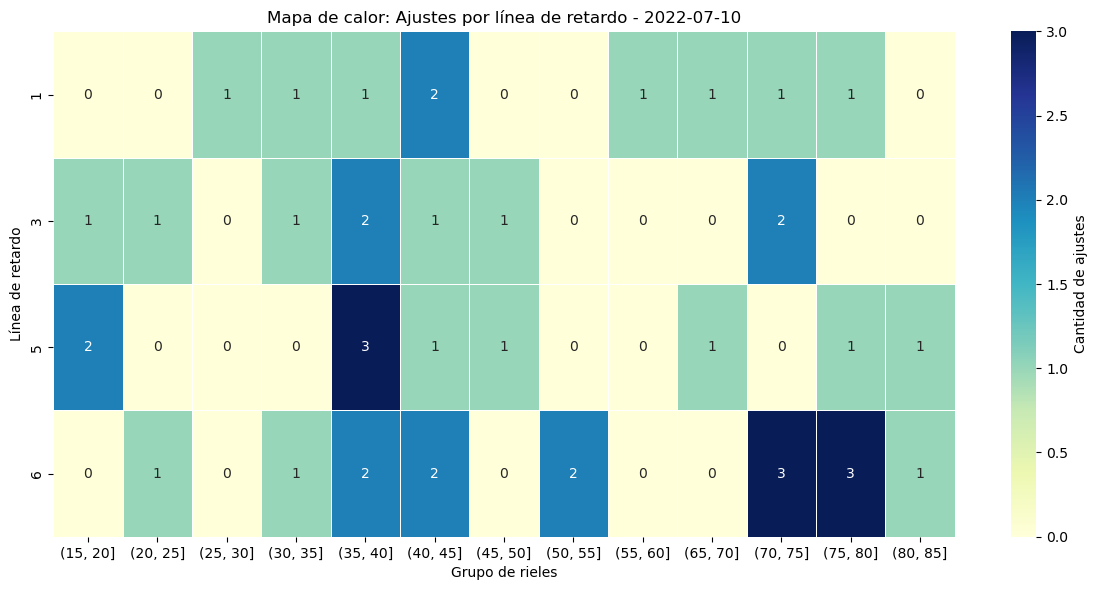

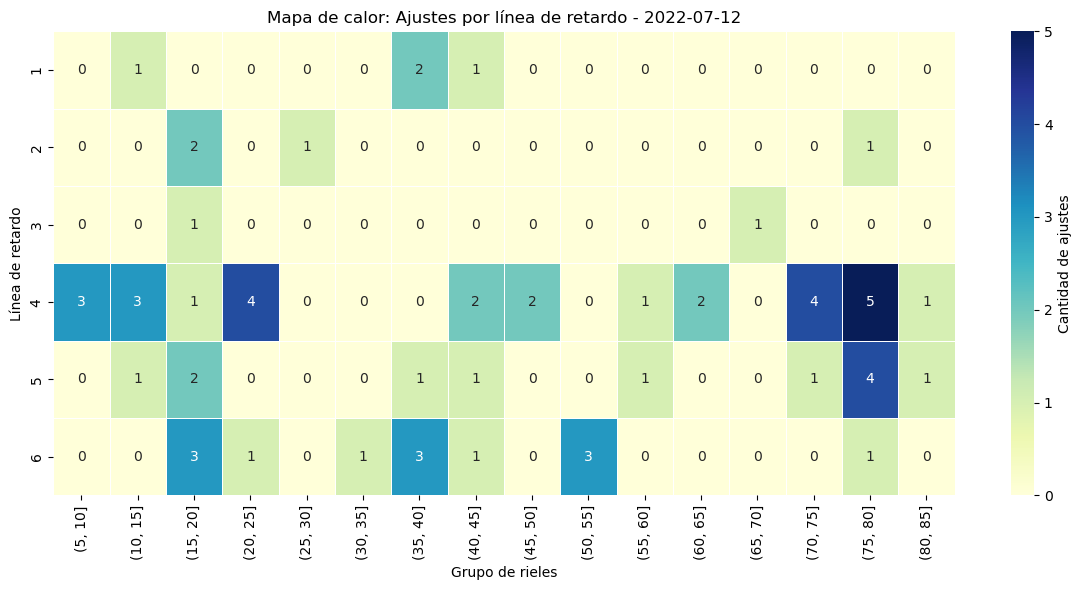

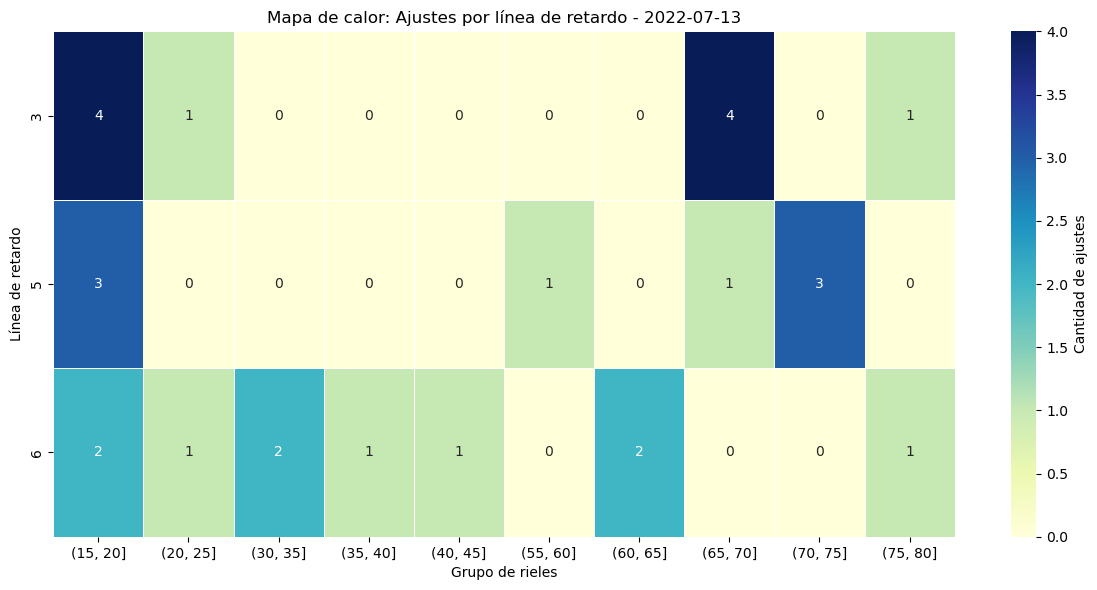

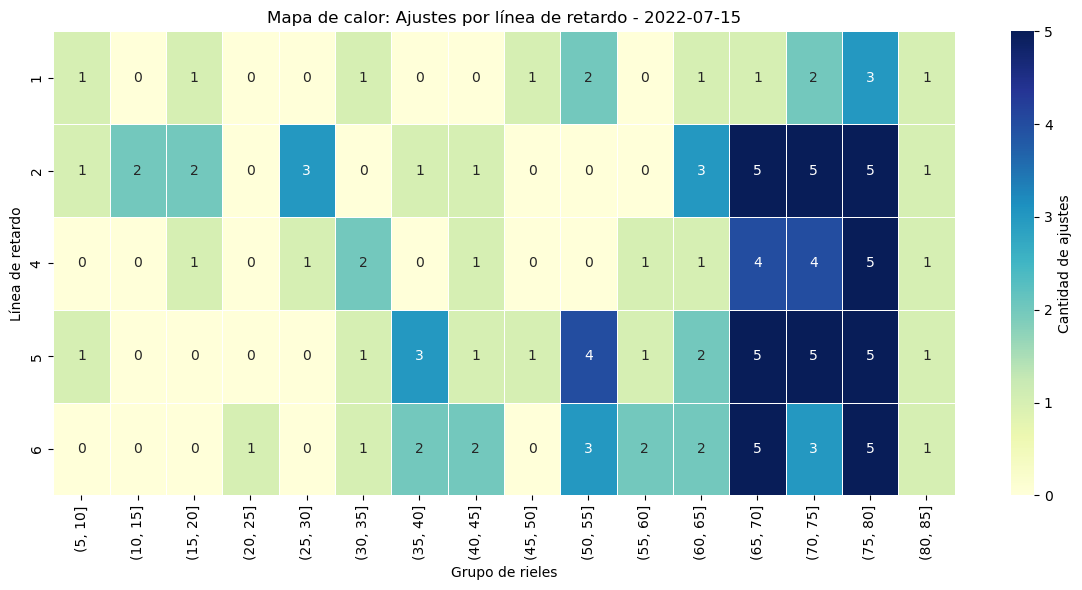

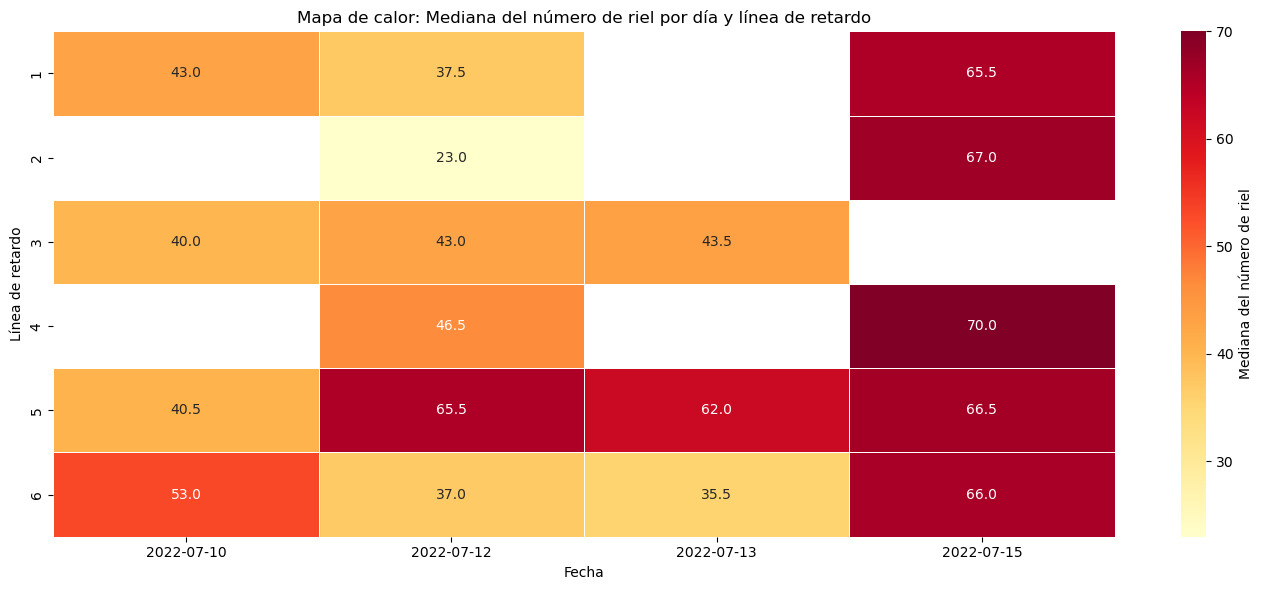

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurar formato datetime y extraer fecha
if not pd.api.types.is_datetime64_any_dtype(df_final["Timestamp"]):
    df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])
df_final["Fecha"] = df_final["Timestamp"].dt.date

# Heatmap por día
for fecha in sorted(df_final["Fecha"].unique()):
    df_dia = df_final[df_final["Fecha"] == fecha].copy()

    if df_dia["Rail number"].nunique() > 1:
        df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5))
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        plt.figure(figsize=(12, 6))
        ax = sns.heatmap(tabla, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5,
                             cbar_kws={"label": "Cantidad de ajustes"})
        plt.title(f"Mapa de calor: Ajustes por línea de retardo - {fecha}")
        plt.xlabel("Grupo de rieles")
        plt.ylabel("Línea de retardo")
        plt.tight_layout()
        plt.show()

# Heatmap resumen con mediana
tabla_medianas = df_final.pivot_table(
    index="Delay line number",
    columns="Fecha",
    values="Rail number",
    aggfunc="median"
)

plt.figure(figsize=(14, 6))
sns.heatmap(tabla_medianas, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5,
                cbar_kws={"label": "Mediana del número de riel"})
plt.title("Mapa de calor: Mediana del número de riel por día y línea de retardo")
plt.xlabel("Fecha")
plt.ylabel("Línea de retardo")
plt.tight_layout()
plt.show()

In [9]:
# Heatmap 1 con plotly

import plotly.express as px
import pandas as pd

# Asegurar formato datetime y extraer fecha
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"])
df_final["Fecha"] = df_final["Timestamp"].dt.date

# Iterar por cada día
for fecha in sorted(df_final["Fecha"].unique()):
    df_dia = df_final[df_final["Fecha"] == fecha].copy()

    if df_dia["Rail number"].nunique() > 1:
        df_dia["rail_bin"] = pd.cut(df_dia["Rail number"], bins=range(0, df_dia["Rail number"].max() + 10, 5))
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        fig = px.imshow(
            tabla.values,
            labels=dict(x="Grupo de rieles", y="Línea de retardo", color="Cantidad de ajustes"),
            x=[str(c) for c in tabla.columns],
            y=tabla.index,
            text_auto=True,
            color_continuous_scale="YlGnBu",
            aspect="auto",
            title=f"Mapa de calor: Ajustes por línea de retardo - {fecha}"
        )
        fig.update_layout(xaxis_title="Grupo de rieles", yaxis_title="Línea de retardo")
        fig.show()

In [10]:
# Heatmap 2 con plotly
tabla_medianas = df_final.pivot_table(
    index="Delay line number",
    columns="Fecha",
    values="Rail number",
    aggfunc="median"
)

fig = px.imshow(
    tabla_medianas.values,
    labels=dict(x="Fecha", y="Línea de retardo", color="Mediana del número de riel"),
    x=[str(c) for c in tabla_medianas.columns],
    y=tabla_medianas.index,
    text_auto=".1f",
    color_continuous_scale="YlOrRd",
    aspect="auto",
    title="Mapa de calor: Mediana del número de riel por día y línea de retardo"
)
fig.update_layout(xaxis_title="Fecha", yaxis_title="Línea de retardo")
fig.show()

In [22]:
import ipywidgets as widgets
import plotly.express as px

# Asegurar formato datetime y extraer fecha
df_final["Timestamp"] = pd.to_datetime(df_final["Timestamp"], errors="coerce")
df_final["Fecha"] = df_final["Timestamp"].dt.date

# Crear selector de fechas
fechas_unicas = sorted(df_final["Fecha"].dropna().unique())
selector_fecha = widgets.Dropdown(
    options=fechas_unicas,
    description="Fecha:",
    style={'description_width': 'initial'}
)

def mostrar_heatmap(fecha):
    df_dia = df_final[df_final["Fecha"] == fecha].copy()

    if df_dia.empty:
        print(f"No hay datos para la fecha {fecha}")
        return

    if df_dia["Rail number"].nunique() > 1:
        # Agrupar rieles en intervalos de 5
        max_rail = df_dia["Rail number"].max()
        df_dia["rail_bin"] = pd.cut(
            df_dia["Rail number"],
            bins=range(0, int(max_rail) + 10, 5)
        )

        # Crear tabla de conteo
        tabla = pd.crosstab(df_dia["Delay line number"], df_dia["rail_bin"])

        if tabla.empty:
            print(f"Tabla vacía para la fecha {fecha}")
            return

        # Graficar heatmap interactivo
        fig = px.imshow(
            tabla.values,
            labels=dict(x="Grupo de rieles", y="Línea de retardo", color="Cantidad de ajustes"),
            x=[str(c) for c in tabla.columns],
            y=tabla.index,
            text_auto=True,
            color_continuous_scale="YlGnBu",
            aspect="auto",
            title=f"Mapa de calor: Ajustes por línea de retardo - {fecha}"
        )
        fig.update_layout(xaxis_title="Grupo de rieles", yaxis_title="Línea de retardo")
        fig.show()
    else:
        print(f"No hay suficientes valores únicos de Rail number para {fecha}")

# Conectar el selector al gráfico
widgets.interact(mostrar_heatmap, fecha=selector_fecha)

interactive(children=(Dropdown(description='Fecha:', options=(datetime.date(2022, 7, 10), datetime.date(2022, …

<function __main__.mostrar_heatmap(fecha)>